## ClariQ: larifying Questions for Open-Domain Dialogue Systems

Two-task challenge: 
- Assign a score to whether a query needs clarification, from 1 (does not need clarification) to 4 (needs clarification)
- Whenever a query needs clarification, pick one clarifying question from an apposite question bank 

On this notebook we will only focus on step one and I may pick it up later for step 2. Let's get started!

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from nltk.corpus import stopwords
from string import punctuation 
from transformers import AutoTokenizer
from transformers import create_optimizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/clariQ/data/train.tsv', sep = '\t')
dev = pd.read_csv('/content/drive/MyDrive/clariQ/data/dev.tsv', sep = '\t')
test = pd.read_csv('/content/drive/MyDrive/clariQ/data/test_with_labels.tsv', sep = '\t') 

In [5]:
print(f'Train set: {len(train)} obs, \nDev set: {len(dev)}, \nTest set: {len(test)}')
train.head()

Train set: 9176 obs, 
Dev set: 2313, 
Test set: 4499


,topic_id,initial_request,topic_desc,clarification_need,facet_id,facet_desc,question_id,question,answer
0,1,Tell me about Obama family tree.,Find information on President Barack Obama\'s ...,2,F0001,"Find the TIME magazine photo essay ""Barack Oba...",Q00384,are you interested in seeing barack obamas family,yes am interested in obamas family
1,1,Tell me about Obama family tree.,Find information on President Barack Obama\'s ...,2,F0001,"Find the TIME magazine photo essay ""Barack Oba...",Q03442,would you like to know barack obamas geneology,yes i want to know who made up his family
2,1,Tell me about Obama family tree.,Find information on President Barack Obama\'s ...,2,F0001,"Find the TIME magazine photo essay ""Barack Oba...",Q03402,would you like to know about obamas ancestors,yes this is what am looking for
3,1,Tell me about Obama family tree.,Find information on President Barack Obama\'s ...,2,F0001,"Find the TIME magazine photo essay ""Barack Oba...",Q03725,would you like to know who is currently alive ...,no find the barack obamas family tree time mag...
4,1,Tell me about Obama family tree.,Find information on President Barack Obama\'s ...,2,F0001,"Find the TIME magazine photo essay ""Barack Oba...",Q00769,are you looking for biological information on ...,no i need the specific time magazine article t...


In [6]:
#Requests are repeated based on the amounts of clarification questions. The real lengths are:
print(len(train['initial_request'].unique()), len(dev['initial_request'].unique()), len(test['initial_request'].unique()), )

187 50 62


In [7]:
train_q = train.drop_duplicates(subset=['initial_request'])
dev_q = dev.drop_duplicates(subset=['initial_request'])
test_q = test.drop_duplicates(subset=['initial_request'])

print(len(train_q), len(dev_q),len(test_q))

187 50 62


Target label distribution in train and dev set. We are not allowed to look at the test set until we get our results!

The distributions look balanced across train and dev set (with greater frequency at values 2 and 3). We see that class 1 for the dev set is just slightly more unbalanced in favor of class 4, but this will not be an issue!

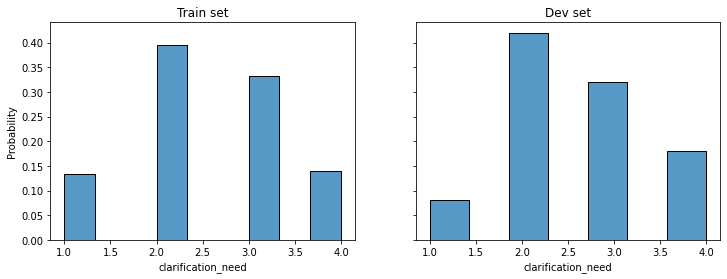

In [8]:
fig, axs = plt.subplots(1,2, sharey = True, figsize = (12,4)) 
sns.histplot(data = train_q, x = 'clarification_need', ax = axs[0], stat = 'probability')
axs[0].set_title('Train set')
sns.histplot(data = dev_q, x = 'clarification_need', ax = axs[1], stat = 'probability')
axs[1].set_title('Dev set')
plt.show()

In [9]:
colX = 'initial_request'
coly = 'clarification_need'

In [10]:
X_train = train_q[colX]
y_train = train_q[coly]-1

X_dev = dev_q[colX]
y_dev = dev_q[coly]-1

X_test = test_q[colX]
y_test = test_q[coly]-1

In [11]:
# #Remove stopwords and punctuation
# sw = set(stopwords.words('english'))
# punct = list(punctuation)
# sw.update(punct)

#only remove punctuation
sw = list(punctuation)

def clean_data(txt):
    col = [i.strip() for i in txt.split()  if i.strip().lower() not in sw if i.strip().isalpha()]
    return ' '.join(col)

X_train = X_train.apply(lambda x: clean_data(x))
X_dev = X_dev.apply(lambda x: clean_data(x))
X_test = X_test.apply(lambda x: clean_data(x))

In [12]:
# #Exponential decay after n epochs
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [13]:
model_name = "cardiffnlp/twitter-roberta-base-emotion" #"cardiffnlp/twitter-roberta-base-emotion" "google/electra-large-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preproc(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            padding = 'max_length',
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

nwords = 20
train_input_ids, train_attention_masks = preproc(X_train,nwords)
dev_input_ids, dev_attention_masks = preproc(X_dev,nwords)
test_input_ids, test_attention_masks = preproc(X_test,nwords)

input_ids = tf.keras.layers.Input(shape=(nwords,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(nwords,), name='attention_mask', dtype='int32')

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/7
47/47 [==============================] - 119s 2s/step - loss: 1.3660 - val_loss: 1.3013 - lr: 1.0000e-04
Epoch 2/7
47/47 [==============================] - 86s 2s/step - loss: 1.3064 - val_loss: 1.2460 - lr: 1.0000e-04
Epoch 3/7
47/47 [==============================] - 86s 2s/step - loss: 1.2262 - val_loss: 1.2899 - lr: 1.0000e-04
Epoch 4/7
47/47 [==============================] - 86s 2s/step - loss: 1.0731 - val_loss: 1.4934 - lr: 9.0484e-05
Epoch 5/7
47/47 [==============================] - 93s 2s/step - loss: 0.8481 - val_loss: 1.5705 - lr: 8.1873e-05
Epoch 6/7
47/47 [==============================] - 85s 2s/step - loss: 0.5223 - val_loss: 1.5385 - lr: 7.4082e-05
Epoch 7/7
47/47 [==============================] - 86s 2s/step - loss: 0.3524 - val_loss: 1.8161 - lr: 6.7032e-05


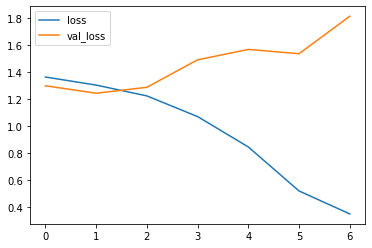

cardiffnlp/twitter-roberta-base-emotion 0.0001 4 7
[3 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1
 1 1 1 1 1 3 1 2 3 1 1 2 1 1 2 1 0 1 3 2 2 2 1 0 1]
Precision:  0.4332333083270818
Recall:  0.4838709677419355
F1: 0.44645161290322577


In [20]:
lrate = 0.0001 
nepochs = 7 
batchsize = 4

def scheduler(epoch, lr):
          if epoch < nepochs //2:
              return lr
          else:
              return lr * tf.math.exp(-0.1)

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_input_ids, train_attention_masks = preproc(X_train,nwords)
dev_input_ids, dev_attention_masks = preproc(X_dev,nwords)
test_input_ids, test_attention_masks = preproc(X_test,nwords)

input_ids = tf.keras.layers.Input(shape=(nwords,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(nwords,), name='attention_mask', dtype='int32')

model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

model.compile(Adam(learning_rate=lrate))

callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)] 
#              tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,  patience=5, restore_best_weights=True)]

history = model.fit(x = {"input_ids": train_input_ids, "attention_mask": train_attention_masks},
          y = y_train, 
          epochs = nepochs, 
          batch_size = batchsize, callbacks = callbacks,
        validation_data = [{"input_ids": dev_input_ids, "attention_mask": dev_attention_masks}, y_dev])

metrics = pd.DataFrame(history.history)

metrics[['loss','val_loss']].plot()
plt.show()

y_preds = model.predict(
        {"input_ids": test_input_ids, "attention_mask": test_attention_masks}
    )
y_pred = y_preds['logits'].argmax(axis=-1)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(model_name, lrate, batchsize, nepochs)
print(y_pred)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1:', f1)

In [28]:
#Save results
pd.DataFrame({'topic_id' : y_test.index, 'y_pred' : y_pred}).to_csv('res1.tsv',header = False, index = False, sep = '\t')